In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Посмотрим на данные

In [2]:
train = pd.read_csv('data/dm3/open100.csv')

In [3]:
print(train.shape)
train.head()

(27442600, 8)


,id,TX,TY,X,Y,Z,signal,data_ind
0,0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,0,1
1,1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,0,1
2,2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,0,1
3,3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,0,1
4,4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,0,1


In [4]:
%matplotlib inline

# Идея решения

 - Зафитим многочлен 3 порядка по каждой из осей
 - Надеемся, что шума достаточно много, и полученная кривая поймает именно шум
 - Вычтем кривую из координат
 - Обучимся с доп. фичами

## Пример вычитания тренда

In [17]:
col = 'Y'
ind = train[train.data_ind == 1]

In [18]:
y, x = np.histogram(ind[col], bins=200)
slc = slice(3, -3)
x, y = x[:-1][slc], y[slc]
params = np.polyfit(x, y, 4)
lin = 0
for par in params:
    lin = lin * x + par

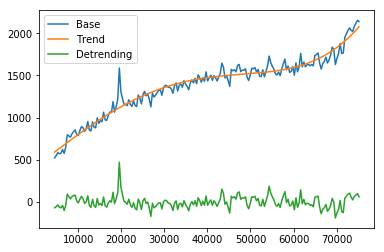

In [21]:
plt.plot(x, y, label='Base')
plt.plot(x, lin, label='Trend')
plt.plot(x, y - lin, label='Detrending')
plt.legend()

Видно, что взяв аргмаксимум, можно найти примерную точку начала сигнала.

In [22]:
def get_begin(ind):
    """
    Fits a 3rd degree curve for each dimnesion
    """
    res = []
    for col in ['X', 'Y', 'Z']:
        y, x = np.histogram(ind[col], bins=200)
        slc = slice(3, -3)
        x, y = x[:-1][slc], y[slc]
        params = np.polyfit(x, y, 3)
        lin = 0
        for par in params:
            lin = lin * x + par
        
        res.append(x[np.argmax(y - lin)])
    return res

def prepare(df):
    """
    Adds detrended features to df
    """
    result = []
    for index in df.data_ind.unique():
        ind = df[df.data_ind == index].copy()
        begin = get_begin(ind)
        ind['dX'] = ind.X - begin[0]
        ind['dY'] = ind.Y - begin[1]
        ind['dZ'] = ind.Z - begin[2]
        result.append(ind)
    return pd.concat(result)

In [23]:
df = prepare(train)

In [24]:
df.head()

,id,TX,TY,X,Y,Z,signal,data_ind,dX,dY,dZ
0,0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,0,1,97.914844,42163.540386,-39792.075
1,1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,0,1,34902.684375,15179.516948,290.925
2,2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,0,1,17041.910938,10826.145854,-30741.075
3,3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,0,1,18857.543750,39909.915386,28736.925
4,4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,0,1,20263.004688,40563.005229,10634.925


## Обучаемся

In [18]:
import lightgbm as lgb

In [23]:
y_train = df['signal']
X_train = df.drop(['signal', 'id', 'data_ind'],axis=1)

In [24]:
X_train.head()

,TX,TY,X,Y,Z,dX,dY,dZ
0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,97.914844,42163.540386,-39792.075
1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,34902.684375,15179.516948,290.925
2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,17041.910938,10826.145854,-30741.075
3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,18857.543750,39909.915386,28736.925
4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,20263.004688,40563.005229,10634.925


In [25]:
lgb_train = lgb.Dataset(X_train, y_train)

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

In [27]:
num_round = 20
lgb.cv(params, lgb_train, num_round, nfold=3)

{'auc-mean': [0.8014889871075493,
  0.9064155951381249,
  0.9060223982582297,
  0.9065437249797562,
  0.9117225116275929,
  0.9158095689226048,
  0.9161613950831352,
  0.9227961577145022,
  0.9252479913732191,
  0.9264630000945698,
  0.926848859525801,
  0.9260509611426236,
  0.9259351938063577,
  0.9256542228424202,
  0.9264738008226169,
  0.926369348951623,
  0.926322762589618,
  0.9261627463616734,
  0.9258483343038372,
  0.9255588455783985],
 'auc-stdv': [0.005797454249275077,
  0.0010008906683600552,
  0.0008185128065904354,
  0.0006853181320712296,
  0.00029827647826444106,
  0.0002501017217037329,
  0.0005462982002961713,
  0.00037522393826062457,
  0.001428236969082335,
  0.0013178393765076628,
  0.0010059338848347615,
  0.0010376838232343175,
  0.0011900729809085574,
  0.0012073383441736129,
  0.00184425193560914,
  0.0017976454013159445,
  0.0018917492364595948,
  0.0018096575844834821,
  0.0016379015793856408,
  0.0016233386196716948]}

Вполне неплохое качество, для такой простой идеи.

## Финальная модель


In [28]:
num_round = 100
bst = lgb.train(params, lgb_train, num_round)

In [29]:
test = pd.read_csv('data/dm3/test_50.csv')

## Предсказание

In [30]:
df_test = prepare(test)

In [45]:
X_test = df_test.drop(['id', 'data_ind'], 1)

In [46]:
ypred = bst.predict(X_test)

Чтобы занимать в 2 раза меньше места, конвертируем ответы в `float16`

In [59]:
result = pd.DataFrame(data={'id': df_test.id.astype(int), 'signal': ypred.astype('float16')})

In [60]:
print(result.shape)
result.head()

(13726164, 2)


,id,signal
0,0,0.004601
1,1,0.009537
2,2,0.008430
3,3,0.005550
4,4,0.004311


## Сохраняем результат

In [61]:
result.to_csv('submit2.csv', index=False)